In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import re
import statsmodels
import statsmodels.api as sm
import lightgbm as lgbe


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score

import shap 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df_train.drop('id', axis=1, inplace=True)
id = df_test['id']
df_test.drop('id', axis=1, inplace=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [6]:
df_train.describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


In [7]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [8]:
df_train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [9]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [10]:
df_train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [11]:
df_train['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [12]:
def preprocess_data(df):
    # Handle missing values and replace specific categories
    df['fuel_type'] = df['fuel_type'].fillna('None')
    df['fuel_type'] = df['fuel_type'].replace({'–': 'none', 'not supported': 'none'})
    
    df['accident'] = df['accident'].fillna('None reported')
    
    df['clean_title'] = df['clean_title'].fillna('No')
    
    return df


In [13]:
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

In [14]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand           0.0
model           0.0
model_year      0.0
milage          0.0
fuel_type       0.0
engine          0.0
transmission    0.0
ext_col         0.0
int_col         0.0
accident        0.0
clean_title     0.0
price           0.0
dtype: float64

In [15]:
for column in df_train.columns:
    print(column, df_train[column].nunique())

brand 57
model 1897
model_year 34
milage 6651
fuel_type 7
engine 1117
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 2
price 1569


In [16]:
def age_features(df):
    df['Vehicle_Age'] = 2024 - df['model_year'] # how much old is the vehicle
    df['Milage_Per_Year'] = df['milage'] / df['Vehicle_Age'] # milage per each year
    df['Milage_With_Age'] = df.groupby('Vehicle_Age')['milage'].transform('mean') # mean of vehicle age and milage
    df['Milage_Per_Year_With_Age'] = df.groupby('Vehicle_Age')['Milage_Per_Year'].transform('mean') # mean of milage per year and age

    return df

df_train = age_features(df_train)
df_test = age_features(df_test)

In [17]:
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns

In [18]:
categorical_columns

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')

In [19]:
def visualize_unique_values(df, categorical_columns):
    for column in categorical_columns:
        unique_vals = df[column].unique()
        print(f"\nColumn: {column}")
        print(f"Unique values ({len(unique_vals)}): {unique_vals}\n")

# Call the function for the training data
visualize_unique_values(df_train, categorical_columns)


Column: brand
Unique values (57): ['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']


Column: model
Unique values (1897): ['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']


Column: fuel_type
Unique values (7): ['Gasoline' 'E85 Flex Fuel' 'None' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 'none']


Column: engine
Unique values (1117): ['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cyli

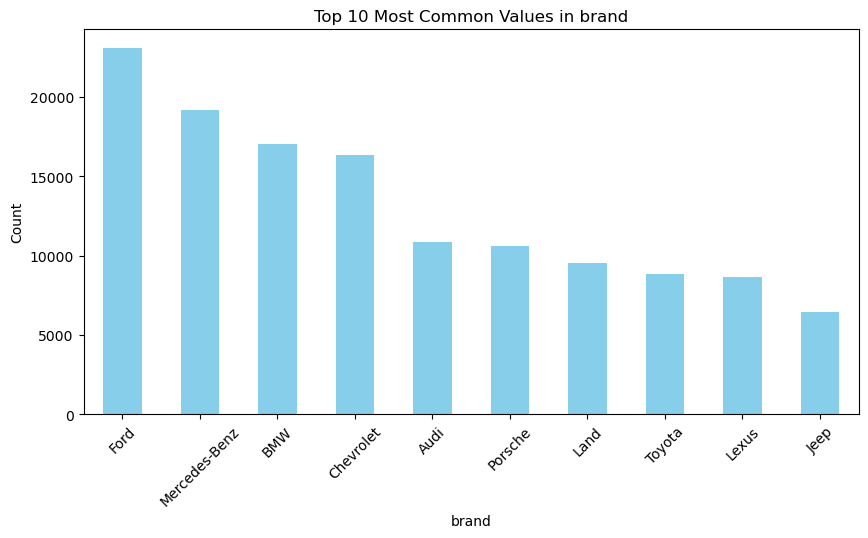

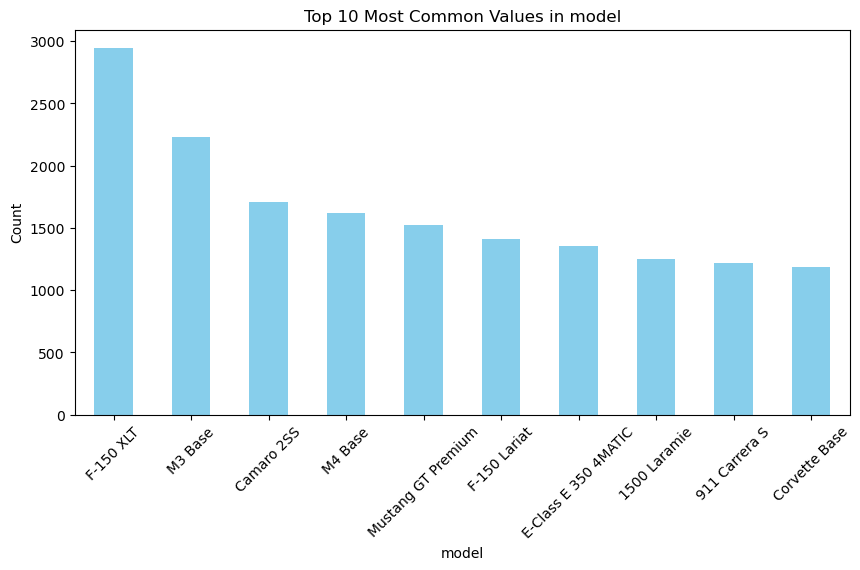

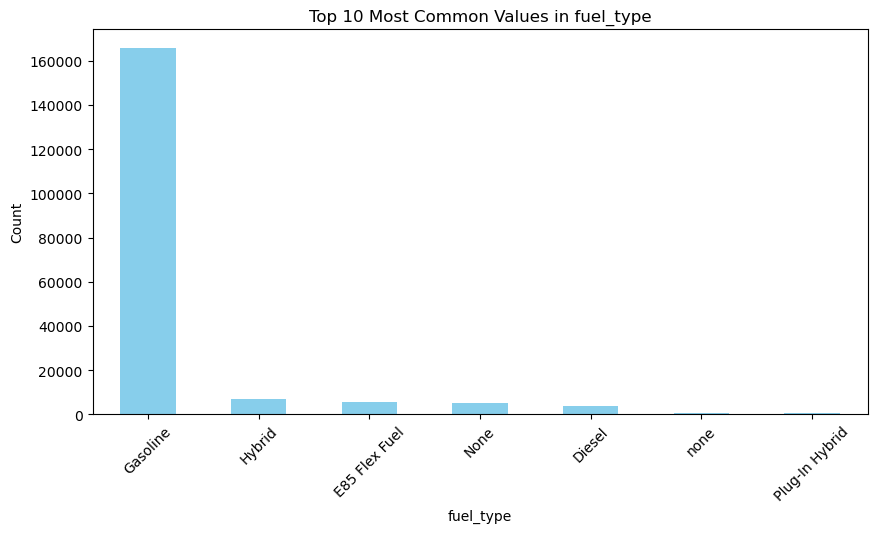

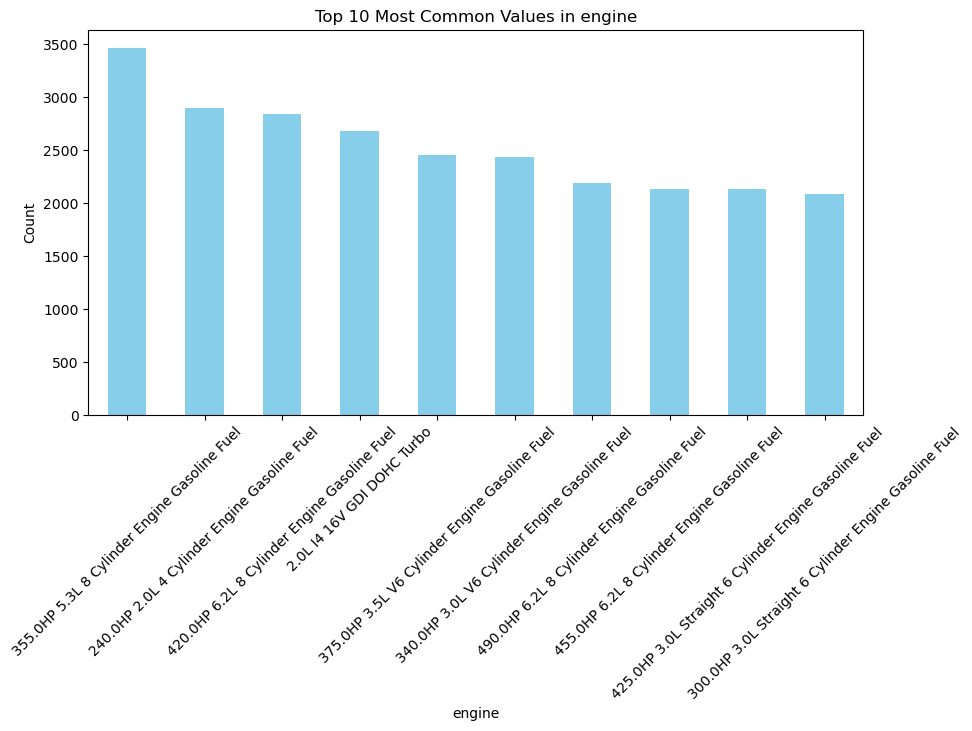

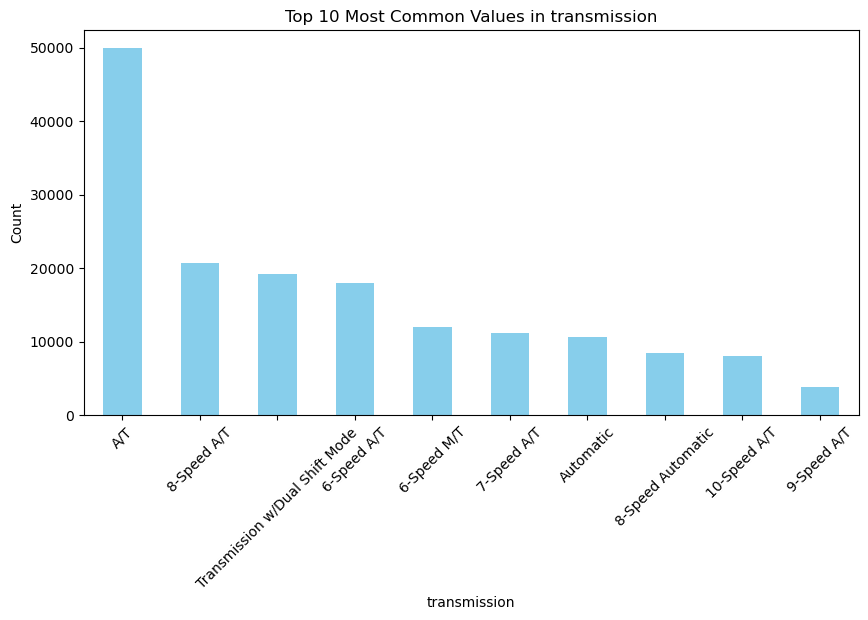

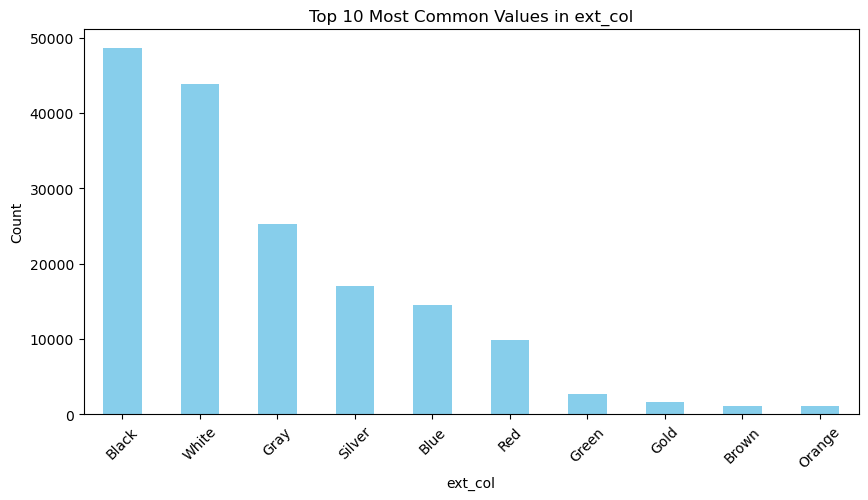

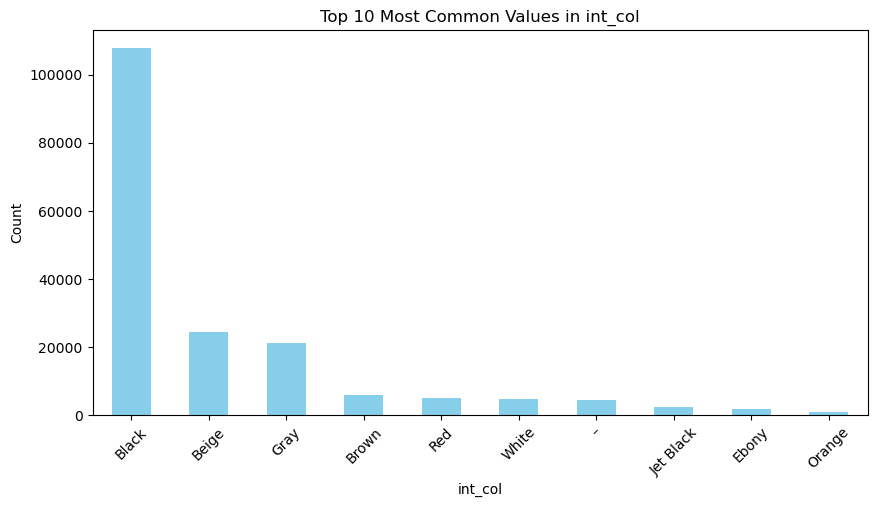

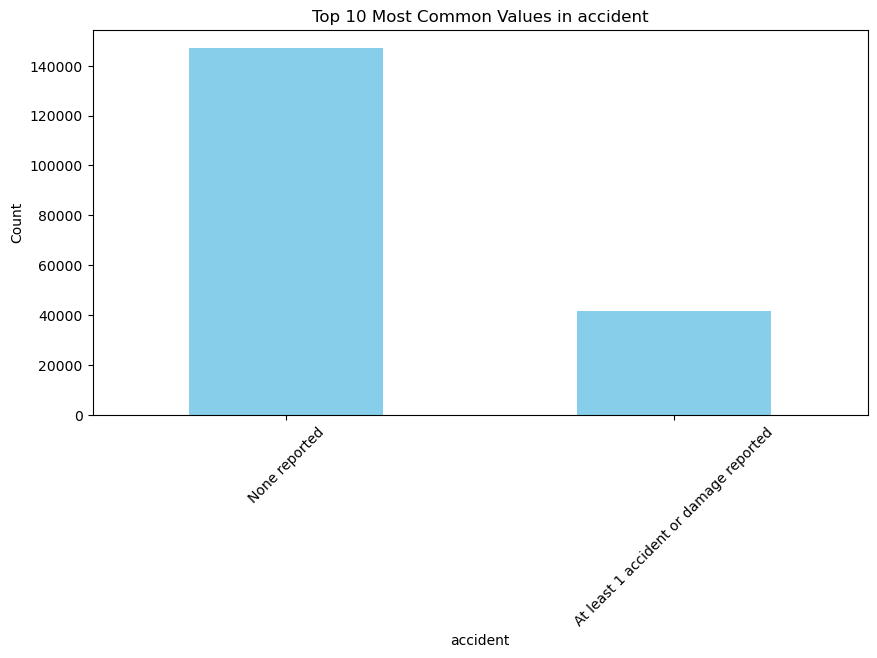

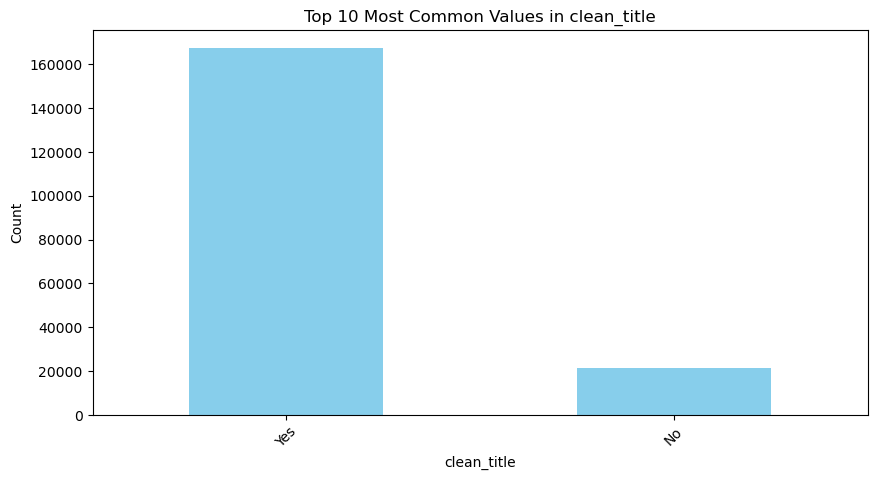

In [20]:
def visualize_top_10_categorical(df, categorical_columns):
    for column in categorical_columns:
        plt.figure(figsize=(10, 5))
        top_10_values = df[column].value_counts().head(10)
        
        top_10_values.plot(kind='bar', color='skyblue')
        plt.title(f'Top 10 Most Common Values in {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Call the function to plot the top 10 distributions for training data
visualize_top_10_categorical(df_train, categorical_columns)


In [21]:
def luxury_features(df):
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                        'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                        'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0) # 1 if the car is luxury or not
    
    return df

df_train = luxury_features(df_train)
df_test = luxury_features(df_test)

In [22]:
def age_features(df):
    df['Vehicle_Age'] = 2024 - df['model_year'] # how much old is the vehicle
    df['Milage_Per_Year'] = df['milage'] / df['Vehicle_Age'] # milage per each year
    df['Milage_With_Age'] = df.groupby('Vehicle_Age')['milage'].transform('mean') # mean of vehicle age and milage
    df['Milage_Per_Year_With_Age'] = df.groupby('Vehicle_Age')['Milage_Per_Year'].transform('mean') # mean of milage per year and age

    return df

df_train = age_features(df_train)
df_test = age_features(df_test)

In [23]:
def clean_transform_transmission(df):
    df['transmission'] = df['transmission'].replace({
        '7-Speed A/T': 'A/T',
        '6 Speed At/Mt': 'At/Mt',
        '8-Speed A/T': 'A/T',
        '10-Speed Automatic': 'A/T',
        '1-Speed A/T': 'A/T',
        '6-Speed A/T': 'A/T',
        '10-Speed A/T': 'A/T',
        '9-Speed A/T': 'A/T',
        '8-Speed Automatic': 'A/T',
        '9-Speed Automatic': 'A/T',
        '5-Speed A/T': 'A/T',
        'Automatic': 'A/T',
        '7-Speed Automatic with Auto-Shift': 'A/T',
        'CVT Transmission': 'CVT',
        '5-Speed M/T': 'M/T',
        '6-Speed M/T': 'M/T',
        '6-Speed Automatic': 'A/T',
        '4-Speed Automatic': 'A/T',
        '7-Speed M/T': 'M/T',
        '2-Speed A/T': 'A/T',
        '1-Speed Automatic': 'A/T',
        'Automatic CVT': 'CVT',
        '4-Speed A/T': 'A/T',
        '6-Speed Manual': 'M/T',
        'Transmission Overdrive Switch': 'A/T',
        '8-Speed Automatic with Auto-Shift': 'A/T',
        '7-Speed Manual': 'M/T',
        '7-Speed Automatic': 'A/T',
        '9-Speed Automatic with Auto-Shift': 'A/T',
        '6-Speed Automatic with Auto-Shift': 'A/T',
        '6 Speed Mt': 'M/T',
        '6-Speed Electronically Controlled Automatic with O': 'A/T',
        'F': 'NN',
        'CVT-F': 'CVT',
        '8-Speed Manual': 'M/T',
        'Manual': 'M/T',
        'Single-Speed Fixed Gear': 'M/T',
        '8-SPEED AT': 'A/T',
        '5-Speed Automatic': 'A/T',
        '2-Speed Automatic': 'A/T',
        '8-SPEED A/T': 'A/T',
        '10-Speed Automatic with Overdrive': 'A/T',
        '7-Speed DCT Automatic': 'A/T',
        'SCHEDULED FOR OR IN PRODUCTION': 'NN',
        '6-Speed': 'NN',
        'Transmission Overdrive Switch': 'NN',
        '2': 'NN',
        '7-Speed': 'NN',
        '–': 'NN',
        'At/Mt': 'NN'  
    })

    return df

# Apply the function to the training data
df_train = clean_transform_transmission(df_train)
df_test = clean_transform_transmission(df_test)


In [24]:
df_train['transmission'].value_counts()

transmission
A/T                               149486
Transmission w/Dual Shift Mode     19255
M/T                                16411
CVT                                 2834
NN                                   461
Variable                              66
At/Mt                                 20
Name: count, dtype: int64

In [25]:
def group_colors(color):
    color = color.lower().strip()  # Normalize case and remove leading/trailing spaces
    
    if 'black' in color:
        return 'black'
    elif 'white' in color or 'pearl' in color:
        return 'white'
    elif 'blue' in color:
        return 'blue'
    elif 'red' in color:
        return 'red'
    elif 'gray' in color or 'grey' in color:
        return 'gray'
    elif 'silver' in color:
        return 'silver'
    elif 'green' in color:
        return 'green'
    elif 'yellow' in color:
        return 'yellow'
    elif 'brown' in color:
        return 'brown'
    elif 'beige' in color or 'gold' in color:
        return 'beige'
    elif 'purple' in color or 'plum' in color:
        return 'purple'
    elif 'orange' in color:
        return 'orange'
    else:
        return 'other'  # Group less common colors into 'other'

# Apply this function to the 'ext_col' column
df_train['ext_col'] = df_train['ext_col'].apply(group_colors)
df_train['int_col'] = df_train['int_col'].apply(group_colors)
df_test['ext_col'] = df_test['ext_col'].apply(group_colors)
df_test['int_col'] = df_test['int_col'].apply(group_colors)


In [26]:
df_train['ext_col'].value_counts()

ext_col
black     53917
white     49060
gray      26763
silver    18809
blue      15695
red       11399
other      3477
green      2948
beige      2764
brown      1185
orange     1148
yellow      994
purple      374
Name: count, dtype: int64

In [27]:
df_train['int_col'].value_counts()

int_col
black     112677
beige      25173
gray       21589
other      10147
brown       6006
red         5507
white       4916
orange       969
blue         855
silver       429
green        214
yellow        51
Name: count, dtype: int64

In [28]:
df_train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [29]:
# Function to extract the necessary components from the 'engine' column
def extract_engine_features_without_fuel(engine_str):
    # Extract horsepower
    hp_match = re.search(r'(\d+(\.\d+)?HP)', engine_str)
    horsepower = float(hp_match.group(1).replace('HP', '')) if hp_match else None

    # Extract engine size in liters
    engine_size_match = re.search(r'(\d+(\.\d+)?L)', engine_str)
    engine_size = float(engine_size_match.group(1).replace('L', '')) if engine_size_match else None

    # Extract number of cylinders
    cylinder_match = re.search(r'(\d+) Cylinder', engine_str)
    cylinders = int(cylinder_match.group(1)) if cylinder_match else None

    return horsepower, engine_size, cylinders

# Apply the function to the 'engine' column without extracting fuel type
df_train[['horsepower', 'engine_size', 'cylinders']] = df_train['engine'].apply(
    lambda x: pd.Series(extract_engine_features_without_fuel(x))
)

df_test[['horsepower', 'engine_size', 'cylinders']] = df_test['engine'].apply(
    lambda x: pd.Series(extract_engine_features_without_fuel(x))
)

# Check the result
print(df_train[['engine', 'horsepower', 'engine_size', 'cylinders']].head())



                                              engine  horsepower  engine_size  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel       172.0          1.6   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel       252.0          3.9   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...       320.0          5.3   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel       420.0          5.0   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel       208.0          2.0   

   cylinders  
0        4.0  
1        8.0  
2        8.0  
3        8.0  
4        4.0  


In [30]:
df_train['Power_To_Weight_Ratio'] = df_train['horsepower'] / df_train['engine_size']
df_test['Power_To_Weight_Ratio'] = df_test['horsepower'] / df_test['engine_size']

In [31]:
df_train = df_train.drop('engine', axis=1)
df_test = df_test.drop('engine', axis=1)

In [32]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand                        0.000000
model                        0.000000
model_year                   0.000000
milage                       0.000000
fuel_type                    0.000000
transmission                 0.000000
ext_col                      0.000000
int_col                      0.000000
accident                     0.000000
clean_title                  0.000000
price                        0.000000
Vehicle_Age                  0.000000
Milage_Per_Year              0.000000
Milage_With_Age              0.000000
Milage_Per_Year_With_Age     0.000000
Is_Luxury_Brand              0.000000
horsepower                  17.640943
engine_size                  7.539264
cylinders                   20.078713
Power_To_Weight_Ratio       20.095156
dtype: float64

In [33]:
def fill_missing_values(df):
    df['horsepower'].fillna(df['horsepower'].mode()[0], inplace=True)
    df['engine_size'].fillna(df['engine_size'].mode()[0], inplace=True)
    df['cylinders'].fillna(df['cylinders'].mode()[0], inplace=True)
    df['Power_To_Weight_Ratio'].fillna(df['Power_To_Weight_Ratio'].mode()[0], inplace=True)
    return df

df_train = fill_missing_values(df_train)
df_test = fill_missing_values(df_test)

In [34]:
null_columns_perc = 100*((df_train.isnull().sum())/len(df_train))
null_columns_perc

brand                       0.0
model                       0.0
model_year                  0.0
milage                      0.0
fuel_type                   0.0
transmission                0.0
ext_col                     0.0
int_col                     0.0
accident                    0.0
clean_title                 0.0
price                       0.0
Vehicle_Age                 0.0
Milage_Per_Year             0.0
Milage_With_Age             0.0
Milage_Per_Year_With_Age    0.0
Is_Luxury_Brand             0.0
horsepower                  0.0
engine_size                 0.0
cylinders                   0.0
Power_To_Weight_Ratio       0.0
dtype: float64

In [35]:
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['model_year', 'milage', 'price', 'Vehicle_Age', 'Milage_Per_Year',
       'Milage_With_Age', 'Milage_Per_Year_With_Age', 'Is_Luxury_Brand',
       'horsepower', 'engine_size', 'cylinders', 'Power_To_Weight_Ratio'],
      dtype='object')

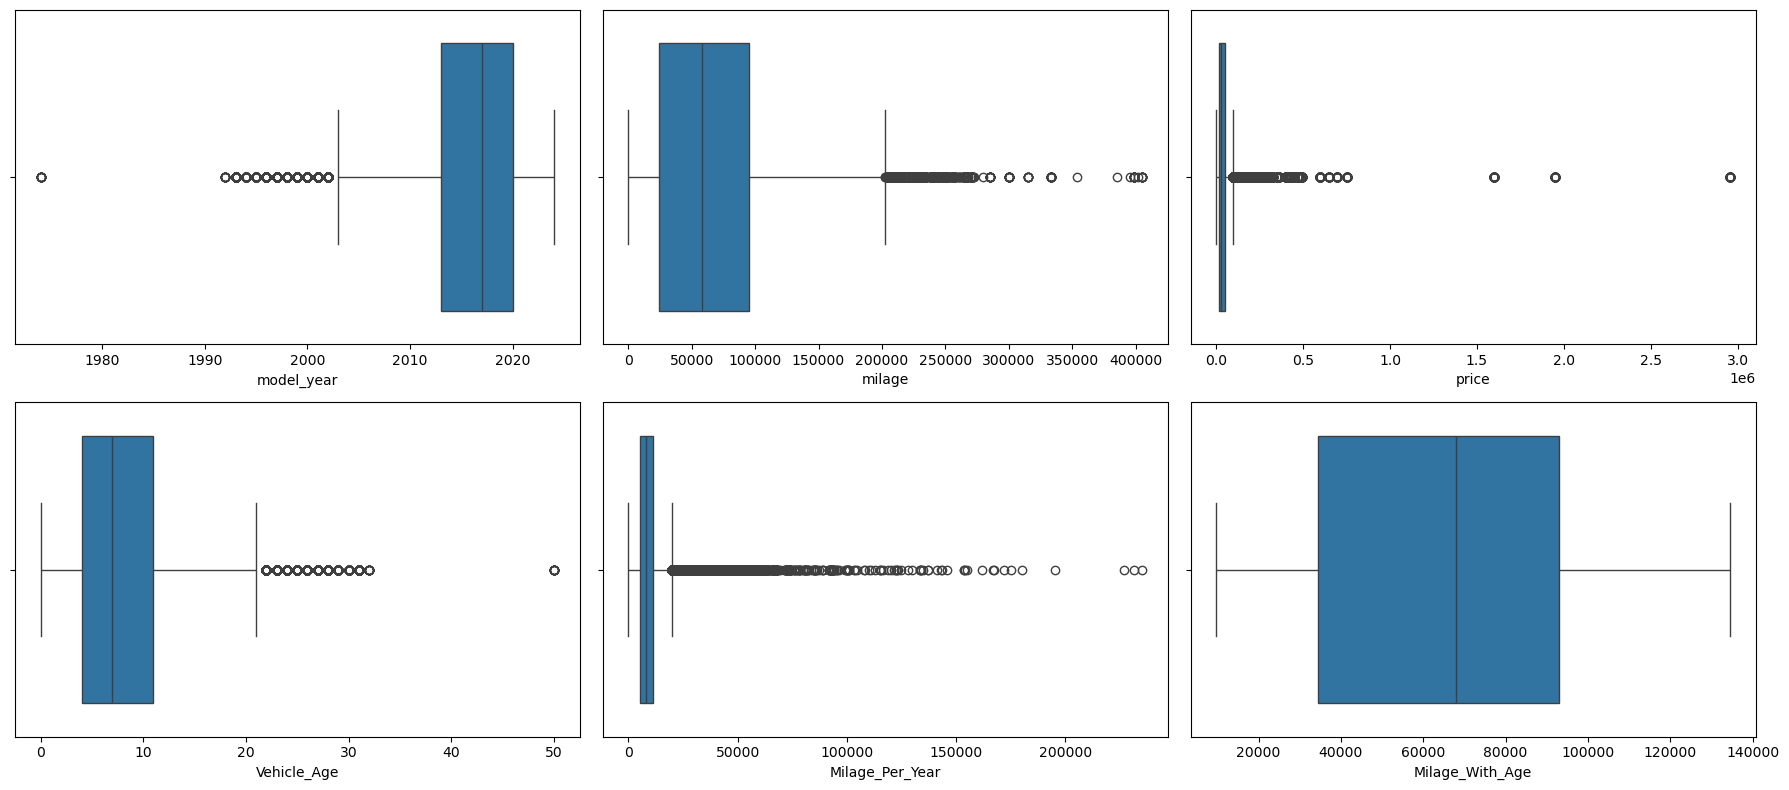

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows and 3 columns for 6 plots

for i, column in enumerate(numerical_columns[:6]):  # Limit to 6 columns
    sns.boxplot(x=df_train[column], ax=ax[i // 3, i % 3])  # Use i // 3 for rows and i % 3 for columns

plt.tight_layout()  # Adjust layout for all subplots
plt.show() 

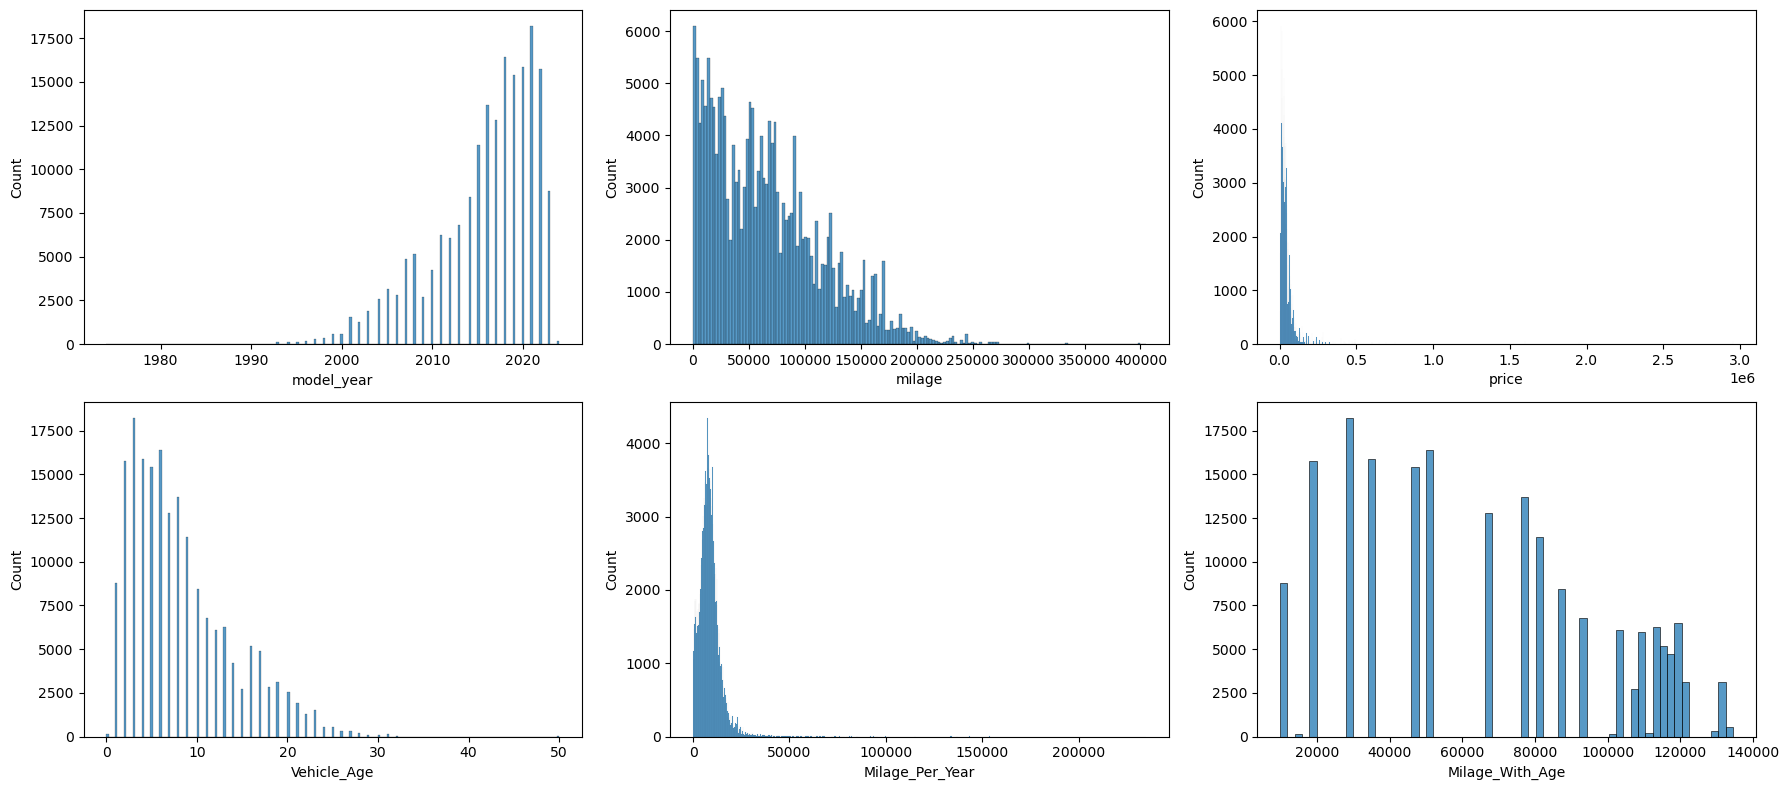

In [37]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows and 3 columns for 6 plots

for i, column in enumerate(numerical_columns[:6]):  # Limit to 6 columns
    sns.histplot(x=df_train[column], ax=ax[i // 3, i % 3])  # Use i // 3 for rows and i % 3 for columns

plt.tight_layout()  # Adjust layout for all subplots
plt.show() 

In [38]:
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col',
       'accident', 'clean_title'],
      dtype='object')

In [39]:
numerical_columns = numerical_columns.drop('price')
numerical_columns

Index(['model_year', 'milage', 'Vehicle_Age', 'Milage_Per_Year',
       'Milage_With_Age', 'Milage_Per_Year_With_Age', 'Is_Luxury_Brand',
       'horsepower', 'engine_size', 'cylinders', 'Power_To_Weight_Ratio'],
      dtype='object')

In [40]:
# Define a transformer class to remove outliers from specified numerical columns
class Outlier_rem(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for outlier removal, return self
        return self
    
    def transform(self, X):
        # List of numerical columns to apply outlier removal
        numcol = numerical_columns
        
        # Iterate over each numerical column
        for col in numcol:
            # Calculate the interquartile range (IQR)
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            
            # Define lower and upper bounds for outliers
            lwr = q1 - (1.5 * iqr)
            upr = q3 + (1.5 * iqr)
            
            # Apply the lower bound: Replace values below the lower bound with the lower bound
            X[col] = X[col].apply(lambda x: lwr if x < lwr else x)
            
            # Apply the upper bound: Replace values above the upper bound with the upper bound
            X[col] = X[col].apply(lambda x: upr if x > upr else x)
        
        return X

# Define a transformer class to encode categorical features using LabelEncoder
class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for label encoding, return self
        return self
    
    def transform(self, X):
        le = LabelEncoder()
        # Iterate over the columns that need encoding 
        for col in categorical_columns:
            # Apply label encoding to the column
            X[col] = le.fit_transform(X[col])
        return X

# Define a transformer class to scale numerical features using StandardScaler
class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for scaling, return self
        return self
    
    def transform(self, X):
        sc = StandardScaler()
        # Check if the dataset contains the target column 'price'
        if 'price' in X.columns:
            # Scale all columns except 'price'
            for col in X.columns:
                if col != 'price':
                    X[col] = sc.fit_transform(X[[col]])
        else:
            # Scale all columns in the dataset
            for col in X.columns:
                X[col] = sc.fit_transform(X[[col]])
        return X

In [41]:
# Create a pipeline that chains together several preprocessing steps
pipeline = Pipeline([
    ('Outlier', Outlier_rem()),         # Remove outliers by capping them at 1.5 times the IQR
    ('encoding', encoding()),           # Encode categorical features using LabelEncoder
    ('scaling', Scaling())              # Scale numerical features using StandardScaler
])

In [42]:
df_train = pipeline.fit_transform(df_train)
df_test = pipeline.transform(df_test)

<Axes: >

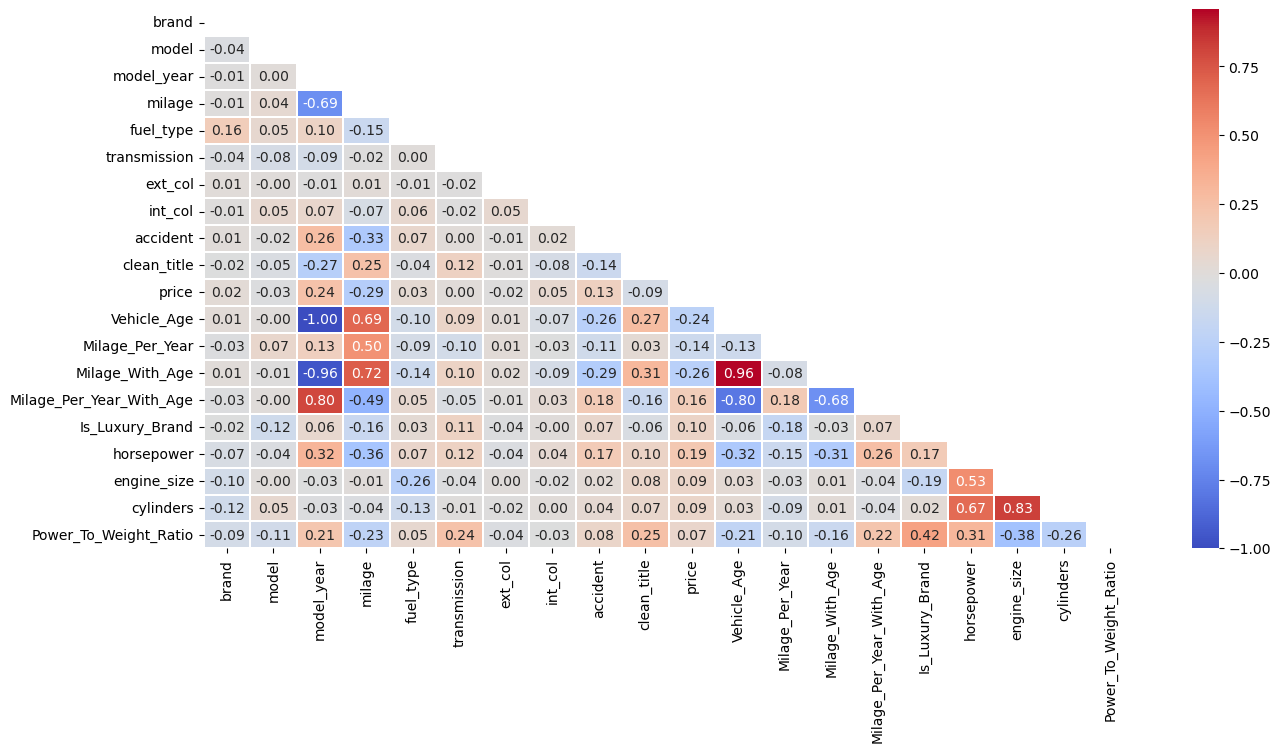

In [43]:
plt.figure(figsize=(15,7))
corr=df_train.corr()
mask=np.triu(corr)
sns.heatmap(corr,mask=mask,linewidth=0.1,annot=True,cmap='coolwarm',fmt='.2f')

In [44]:
X = df_train.drop('price', axis=1)
y = df_train['price']

In [45]:
X.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,Vehicle_Age,Milage_Per_Year,Milage_With_Age,Milage_Per_Year_With_Age,Is_Luxury_Brand,horsepower,engine_size,cylinders,Power_To_Weight_Ratio
0,0.493978,-0.713392,-1.635482,2.808937,-0.075887,-0.487558,1.450997,0.785395,0.531822,0.358008,1.635482,0.900888,1.487596,-1.942901,-0.872544,-1.644977,-1.627339,-1.670113,0.743582
1,0.304919,0.120255,-2.461952,1.597038,-0.075887,-0.487558,0.985462,-0.860682,-1.880330,0.358008,2.461952,-0.406204,1.486329,-1.942901,-0.872544,-0.829016,0.117802,1.244055,-0.894889
2,-0.892449,1.356353,-2.461952,1.463309,-1.773263,-0.487558,-0.876677,0.785395,0.531822,0.358008,2.461952,-0.470563,1.486329,-1.942901,-0.872544,-0.135449,1.180062,1.244055,-1.056809
3,-0.451314,-0.209371,0.201118,-0.941534,-0.075887,2.507851,-1.109444,-0.449163,0.531822,0.358008,-0.201118,-1.215397,0.062968,1.101376,-0.872544,0.884502,0.952435,1.244055,-0.154271
4,0.809075,0.401970,0.935758,-1.189996,-0.075887,-0.487558,-1.109444,-0.860682,0.531822,0.358008,-0.935758,-1.285561,-1.024190,1.195276,1.146075,-1.277795,-1.323836,-1.670113,0.609859


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

https://gursev-pirge.medium.com/comparison-of-regression-analysis-algorithms-db710b6d7528

In [48]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
        'n_estimators': 1000,
        'random_state': 42
    }

    # Initialize the LightGBM model with the trial's parameters
    model = LGBMRegressor(**param, verbose=-1, n_jobs=-1)

    # Perform cross-validation with 5 folds using neg_mean_squared_error as the scoring metric
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

    # Return the average negative MSE (Optuna will maximize this)
    return neg_mse.mean()

# Create the Optuna study (direction='maximize' because neg_mse is maximized to minimize MSE)
study = optuna.create_study(direction="maximize")

# Start optimization with a time limit of 600 seconds and early stopping for unpromising trials
study.optimize(objective, n_trials=150, timeout= 3600, n_jobs=-1)

# Get the best hyperparameters
print("Best Parameters: ", study.best_params)

# Train the model with the best hyperparameters
model_LGB = LGBMRegressor(**study.best_params, random_state=42, verbose=0, n_jobs=-1)

# Use KFold for a more detailed evaluation
kf = KFold(n_splits=15, shuffle=True, random_state=42)

train_scores = []
val_scores = []

[I 2024-09-23 09:46:18,995] A new study created in memory with name: no-name-41a7f023-7a3b-480a-83e6-f2d321c3d7df


[I 2024-09-23 09:47:37,393] Trial 4 finished with value: -5697407026.207041 and parameters: {'learning_rate': 0.07668534488189749, 'max_depth': 28, 'reg_alpha': 0.00306580317856304, 'reg_lambda': 0.0025919672666021693, 'num_leaves': 121, 'subsample': 0.6551542815817751, 'colsample_bytree': 0.3792909598116184}. Best is trial 4 with value: -5697407026.207041.
[I 2024-09-23 09:49:22,541] Trial 5 finished with value: -5508391855.900766 and parameters: {'learning_rate': 0.022837037039357713, 'max_depth': 13, 'reg_alpha': 0.07310241056351238, 'reg_lambda': 2.6561909661222836, 'num_leaves': 119, 'subsample': 0.5802667618326205, 'colsample_bytree': 0.9841812986273832}. Best is trial 5 with value: -5508391855.900766.
[I 2024-09-23 09:50:12,878] Trial 2 finished with value: -5345636337.086591 and parameters: {'learning_rate': 0.0023846424282988267, 'max_depth': 19, 'reg_alpha': 0.11718988338346369, 'reg_lambda': 0.1904110436694794, 'num_leaves': 99, 'subsample': 0.5677856012382266, 'colsample_by

Best Parameters:  {'learning_rate': 0.010276668408263896, 'max_depth': 45, 'reg_alpha': 0.00012010390883592389, 'reg_lambda': 0.0003452552696550256, 'num_leaves': 24, 'subsample': 0.30675749796609425, 'colsample_bytree': 0.25112900646868636}


In [49]:
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fitting the best model
    model_LGB.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], 
                  eval_metric='rmse')

    # Predicting on training and validation sets
    y_train_pred = model_LGB.predict(X_train)
    y_val_pred = model_LGB.predict(X_val)

    # RMSE scores
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_scores.append(train_rmse)
    val_scores.append(val_rmse)

    print(f"Fold {fold}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}")

# Mean RMSE scores
mean_train_rmse = np.mean(train_scores)
mean_val_rmse = np.mean(val_scores)

print(f"\nMean Train RMSE: {mean_train_rmse:.4f}")
print(f"Mean Validation RMSE: {mean_val_rmse:.4f}")

Fold 1: Train RMSE = 74901.1795, Validation RMSE = 65561.0889
Fold 2: Train RMSE = 74479.5739, Validation RMSE = 72406.4124
Fold 3: Train RMSE = 74522.6940, Validation RMSE = 71576.0369
Fold 4: Train RMSE = 75128.9910, Validation RMSE = 61540.4937
Fold 5: Train RMSE = 74588.2169, Validation RMSE = 70171.0011
Fold 6: Train RMSE = 74040.4074, Validation RMSE = 78338.4826
Fold 7: Train RMSE = 73600.8663, Validation RMSE = 83729.4913
Fold 8: Train RMSE = 74081.6385, Validation RMSE = 77644.5064
Fold 9: Train RMSE = 75034.6466, Validation RMSE = 63518.5412
Fold 10: Train RMSE = 73949.5085, Validation RMSE = 79682.4549
Fold 11: Train RMSE = 73228.3312, Validation RMSE = 88584.5375
Fold 12: Train RMSE = 74964.8896, Validation RMSE = 64613.3182
Fold 13: Train RMSE = 74839.8894, Validation RMSE = 66927.3489
Fold 14: Train RMSE = 73695.0617, Validation RMSE = 83020.4343
Fold 15: Train RMSE = 73658.2074, Validation RMSE = 83139.2198

Mean Train RMSE: 74314.2735
Mean Validation RMSE: 74030.2245


In [50]:
# Make predictions on the test set (X_test)
y_test_pred = model_LGB.predict(X_test)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation results
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Test RMSE: 69710.8729
Test MAE: 21978.0093
Test R² Score: 0.1261


In [51]:
df_train.head()

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Milage_Per_Year,Milage_With_Age,Milage_Per_Year_With_Age,Is_Luxury_Brand,horsepower,engine_size,cylinders,Power_To_Weight_Ratio
0,0.493978,-0.713392,-1.635482,2.808937,-0.075887,-0.487558,1.450997,0.785395,0.531822,0.358008,4200,1.635482,0.900888,1.487596,-1.942901,-0.872544,-1.644977,-1.627339,-1.670113,0.743582
1,0.304919,0.120255,-2.461952,1.597038,-0.075887,-0.487558,0.985462,-0.860682,-1.880330,0.358008,4999,2.461952,-0.406204,1.486329,-1.942901,-0.872544,-0.829016,0.117802,1.244055,-0.894889
2,-0.892449,1.356353,-2.461952,1.463309,-1.773263,-0.487558,-0.876677,0.785395,0.531822,0.358008,13900,2.461952,-0.470563,1.486329,-1.942901,-0.872544,-0.135449,1.180062,1.244055,-1.056809
3,-0.451314,-0.209371,0.201118,-0.941534,-0.075887,2.507851,-1.109444,-0.449163,0.531822,0.358008,45000,-0.201118,-1.215397,0.062968,1.101376,-0.872544,0.884502,0.952435,1.244055,-0.154271
4,0.809075,0.401970,0.935758,-1.189996,-0.075887,-0.487558,-1.109444,-0.860682,0.531822,0.358008,97500,-0.935758,-1.285561,-1.024190,1.195276,1.146075,-1.277795,-1.323836,-1.670113,0.609859


In [52]:
y_submission = model_LGB.predict(df_test)

In [53]:
y_submission

array([28806.09296991, 61634.53630863, 53116.28937087, ...,
       32203.01641507, 28952.91566975, 40142.06829016])

In [54]:
predict_LGB =pd.DataFrame({'id':id,'price':y_submission})

In [55]:
predict_LGB.head()

,id,price
0,188533,28806.092970
1,188534,61634.536309
2,188535,53116.289371
3,188536,38364.290488
4,188537,37168.398943


In [56]:
predict_LGB.to_csv('submission_LGB6.csv',index=False)

In [57]:
# Define the objective function for CatBoost
def objective_catboost(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 4, 10),  # Equivalent to max_depth
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),  # L2 regularization
        'iterations': trial.suggest_int('iterations', 500, 2000),  # Number of boosting iterations
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1.0),
        'random_state': 42,
        'verbose': 0
    }

    # Initialize the CatBoost model with the trial's parameters
    model = CatBoostRegressor(**param)

    # Perform cross-validation with 5 folds using neg_mean_squared_error as the scoring metric
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

    # Return the average negative MSE (Optuna will maximize this)
    return neg_mse.mean()

# Run the Optuna study for CatBoost
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=150, timeout=3600, n_jobs=-1)

# Get the best hyperparameters for CatBoost
print("Best CatBoost Parameters: ", study_catboost.best_params)

# Train the best CatBoost model
catboost_params = study_catboost.best_params
model_catboost = CatBoostRegressor(**catboost_params, random_state=42, verbose=0)



[I 2024-09-23 10:48:44,576] A new study created in memory with name: no-name-358686aa-2403-4e6f-b710-07cb486c6c7b
[I 2024-09-23 10:49:05,240] Trial 0 finished with value: -5341562115.414125 and parameters: {'learning_rate': 0.05653003932733588, 'depth': 4, 'l2_leaf_reg': 2.3414344623213337, 'iterations': 666, 'random_strength': 0.001622418361497296, 'bagging_temperature': 0.0018809566942147578}. Best is trial 0 with value: -5341562115.414125.
[I 2024-09-23 10:49:25,505] Trial 1 finished with value: -5312741407.423536 and parameters: {'learning_rate': 0.0212647656483279, 'depth': 4, 'l2_leaf_reg': 7.223209284963564, 'iterations': 738, 'random_strength': 0.0931675277391908, 'bagging_temperature': 0.04286601726835806}. Best is trial 1 with value: -5312741407.423536.
[I 2024-09-23 10:50:04,689] Trial 4 finished with value: -5453083046.916096 and parameters: {'learning_rate': 0.000958204144518388, 'depth': 6, 'l2_leaf_reg': 0.025013500970168617, 'iterations': 1447, 'random_strength': 0.0273

Best CatBoost Parameters:  {'learning_rate': 0.026909364272198335, 'depth': 4, 'l2_leaf_reg': 8.372738304985884, 'iterations': 866, 'random_strength': 0.0036606222975496417, 'bagging_temperature': 0.0009470250458762412}


In [58]:
# Use KFold for a more detailed evaluation
kf = KFold(n_splits=15, shuffle=True, random_state=42)

train_scores = []
val_scores = []

In [59]:
# Iterate through K-Folds
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize CatBoostRegressor with eval_metric
    model_catboost = CatBoostRegressor(
        eval_metric='RMSE',  # Set the evaluation metric here
        iterations=1000,     # You can specify other hyperparameters here
        random_state=42,
        verbose=0  # Set to 0 to suppress iteration output
    )

    # Fitting the CatBoost model
    model_catboost.fit(X_train, y_train, 
                       eval_set=(X_val, y_val),  # Set validation data for evaluation
                       early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
                       verbose=0)  # Set to 0 to suppress iteration output

    # Predicting on training and validation sets
    y_train_pred = model_catboost.predict(X_train)
    y_val_pred = model_catboost.predict(X_val)

    # Calculate RMSE scores for training and validation sets
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Append the RMSE scores to the lists
    train_scores.append(train_rmse)
    val_scores.append(val_rmse)

    print(f"Fold {fold}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}")

# Calculate and print the mean RMSE for training and validation sets
mean_train_rmse = np.mean(train_scores)
mean_val_rmse = np.mean(val_scores)

print(f"\nMean Train RMSE: {mean_train_rmse:.4f}")
print(f"Mean Validation RMSE: {mean_val_rmse:.4f}")


Fold 1: Train RMSE = 71407.8247, Validation RMSE = 63607.5905
Fold 2: Train RMSE = 72029.1035, Validation RMSE = 70882.3293
Fold 3: Train RMSE = 70828.7222, Validation RMSE = 69500.8189
Fold 4: Train RMSE = 72689.5493, Validation RMSE = 60250.7099
Fold 5: Train RMSE = 71515.2002, Validation RMSE = 68692.6615
Fold 6: Train RMSE = 71253.0194, Validation RMSE = 76481.8111
Fold 7: Train RMSE = 70751.1364, Validation RMSE = 82464.0708
Fold 8: Train RMSE = 71306.6247, Validation RMSE = 76262.5594
Fold 9: Train RMSE = 71827.8569, Validation RMSE = 61497.9070
Fold 10: Train RMSE = 70527.2404, Validation RMSE = 77997.5788
Fold 11: Train RMSE = 69662.1451, Validation RMSE = 86732.8461
Fold 12: Train RMSE = 71769.0093, Validation RMSE = 62961.8806
Fold 13: Train RMSE = 72045.6836, Validation RMSE = 65211.3739
Fold 14: Train RMSE = 68989.6722, Validation RMSE = 80956.4986
Fold 15: Train RMSE = 70470.2752, Validation RMSE = 81878.8716

Mean Train RMSE: 71138.2042
Mean Validation RMSE: 72358.6339


In [60]:
# Make predictions on the test set (X_test)
y_test_pred = model_catboost.predict(X_test)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation results
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Test RMSE: 66584.1605
Test MAE: 19369.4549
Test R² Score: 0.2028


In [61]:
y_submission = model_catboost.predict(df_test)

In [62]:
predict_catboost =pd.DataFrame({'id':id,'price':y_submission})

In [63]:
predict_catboost.to_csv('submission_CB2.csv',index=False)

In [64]:
# # Define the objective function for optimization
# def objective(trial):
#     param = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'booster': trial.suggest_categorical('booster', ['gbtree']),
#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',
#     }

#     model = XGBRegressor(**param, random_state=42)
#     score = cross_val_score(model, X, y, cv=5).mean()
#     return score

# # Create the study
# study = optuna.create_study(direction="minmise")

# # Start optimization
# study.optimize(objective, n_trials=20)

# # Get the best parameters
# print("Best Parameters: ", study.best_params)

# # Train with the best parameters
# model_XGB = XGBRegressor(**study.best_params, random_state=42, verbose=0, n_jobs=-1)

# # Train and evaluate with K-Fold
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# train_scores = []
# val_scores = []

In [65]:
# for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Fitting the best model
#     model_XGB.fit(X_train, y_train)

#     # Predicting on training and validation sets
#     y_train_pred = model_XGB.predict(X_train)
#     y_val_pred = model_XGB.predict(X_val)

#     # RMSE scores
#     train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

#     train_scores.append(train_rmse)
#     val_scores.append(val_rmse)

#     print(f"Fold {fold}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}")

# # Mean RMSE scores
# mean_train_rmse = np.mean(train_scores)
# mean_val_rmse = np.mean(val_scores)

# print(f"\nMean Train RMSE: {mean_train_rmse:.4f}")
# print(f"Mean Validation RMSE: {mean_val_rmse:.4f}")

In [ ]:
# # Make predictions on the test set (X_test)
# y_test_pred_XGB = model_XGB.predict(X_test)

# # Evaluate the model on the test set
# test_rmse_XGB = np.sqrt(mean_squared_error(y_test, y_test_pred_XGB))
# test_mae_XGB = mean_absolute_error(y_test, y_test_pred_XGB)
# test_r2_XGB = r2_score(y_test, y_test_pred_XGB)

# # Print the evaluation results
# print(f"Test RMSE: {test_rmse_XGB:.4f}")
# print(f"Test MAE: {test_mae_XGB:.4f}")
# print(f"Test R² Score: {test_r2_XGB:.4f}")

In [ ]:
# y_submission_XGB = model_XGB.predict(df_test)

In [ ]:
# predict_XGB =pd.DataFrame({'id':id,'price':y_submission_XGB})

In [ ]:
# predict_XGB.to_csv('submission_XGB.csv',index=False)

In [ ]:
# data = {
#     'Model': ['XGBoost', 'LightGBM'],
#     'RMSE': [test_rmse_XGB, test_rmse],  # Root Mean Squared Error
#     'MAE': [test_mae_XGB, test_mae],     # Mean Absolute Error
#     'R²': [test_r2_XGB, test_r2]         # R-squared
# }

# df = pd.DataFrame(data)
# df

In [ ]:
# # Create a line plot to compare models
# metrics = ['RMSE', 'MAE', 'R²']
# XGBoost_values = [test_rmse_XGB, test_mae_XGB, test_r2_XGB]
# LightGBM_values = [test_rmse, test_mae, test_r2]

# plt.figure(figsize=(10, 6))

# # Plot XGBoost values
# plt.plot(metrics, XGBoost_values, marker='o', label='XGBoost', color='b')

# # Plot LightGBM values
# plt.plot(metrics, LightGBM_values, marker='o', label='LightGBM', color='g')

# # Add labels and title
# plt.xlabel('Metrics', fontweight='bold')
# plt.ylabel('Values', fontweight='bold')
# plt.title('Performance Comparison of XGBoost vs LightGBM')
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()
